In [126]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
reload(alpenglow.files)
from alpenglow.stitching import stitch, find_shift, apply_shift

In [62]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage
import dask.array as da
from dask import delayed

In [3]:
s3 = boto3.resource('s3')

bucket = s3.Bucket('alpenglowoptics')

ll = list(bucket.objects.all())

In [31]:
phantom = []
for item in ll:
    if item.key.startswith("phantom_2_7_2017/000001"):
        phantom.append(item.key)

In [11]:
phantom[-1]

'phantom_2_7_2017/000001/Thumbs.db'

In [21]:
mkdir ../data/phantom_2_7_2017

In [22]:
mkdir ../data/phantom_2_7_2017/000000

In [23]:
mkdir ../data/phantom_2_7_2017/000001

In [24]:
mkdir ../data/phantom_2_7_2017/000002

In [25]:
#downloading frames from s3 to ec2 instance
for x in range(1,len(phantom)):
    for strip in [0,1,2]:
        fname = "%06d_%05d.tif" % (strip, x)
        af.download_s3('phantom_2_7_2017/%06d/' %strip + fname, '../data/phantom_2_7_2017/%06d/' %strip + fname)

In [47]:
imread = delayed(skimage.io.imread, pure=True)  # Lazy version of imread
filenames = []
strip = 1
for x in range(1,len(phantom)):
    fname = "%06d_%05d.tif" % (strip, x)
    filenames.append('../data/phantom_2_7_2017/%06d/' %strip + fname)



In [48]:
len(filenames)

1800

In [49]:
lazy_values = [imread(filename) for filename in filenames]

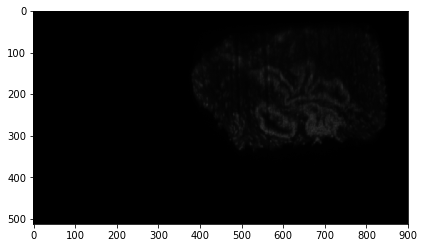

In [50]:
sample = skimage.io.imread(filenames[100])
skimage.io.imshow(sample)

In [51]:
arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]



In [52]:
stack = da.stack(arrays, axis=0)                # Stack all small Dask arrays into one

In [53]:
stack

dask.array<stack-2..., shape=(1800, 512, 900), dtype=uint16, chunksize=(1, 512, 900)>

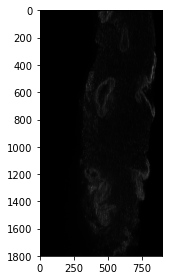

In [54]:
skimage.io.imshow(stack[:,100,:].compute())

In [58]:
for z in range(1,stack.shape[1]):
    filename = 'zstack_%06d_%06d.tif' % (strip, z) 
    tiff.imsave(filename, stack[:,z,:].compute())
zstack = ImageCollection('zstack_%06d_*.tif' % strip )

In [59]:
len(zstack)

511

In [100]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

In [127]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

NameError: name 'delayed' is not defined